# GrammarGraph Feature Demo

GrammarGraph lets you build a directed graph from a context-free grammar (CFG).
A context-free grammar is a mapping from nonterminals to lists of expansion alternatives.
For instance, the following grammar represents a CSV file:

In [1]:
import string
from typing import List, Dict

CSV_GRAMMAR: Dict[str, List[str]] = {
    '<start>': ['<csvline>'],
    '<csvline>': ['<items>'],
    '<items>': ['<item>,<items>', '<item>'],
    '<item>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation + ' \t\n')
}

This particular representation of a grammar is based on the [Fuzzing Book](https://www.fuzzingbook.org/).
Such a grammar can, e.g., be used to create random CSV files (based on Fuzzing Book implementations,
this is independent from GrammarGraph):

In [2]:
from fuzzingbook.GrammarCoverageFuzzer import GrammarCoverageFuzzer

fuzzer = GrammarCoverageFuzzer(CSV_GRAMMAR)

for _ in range(10):
    print(fuzzer.fuzz())

r,#k
!Udi,z`C/,?t.
@sYh,nW
	cK
+
yT
x
N}X
|<q',b,j%,^-="[Hw,S
l,
u,Q,7aO


## Visualization

Using GrammarGraph, we can visualize this grammar based on GraphViz. To make sure everything
fits on the screen, we reduce the number of alternatives for the `<letter>` nonterminal.

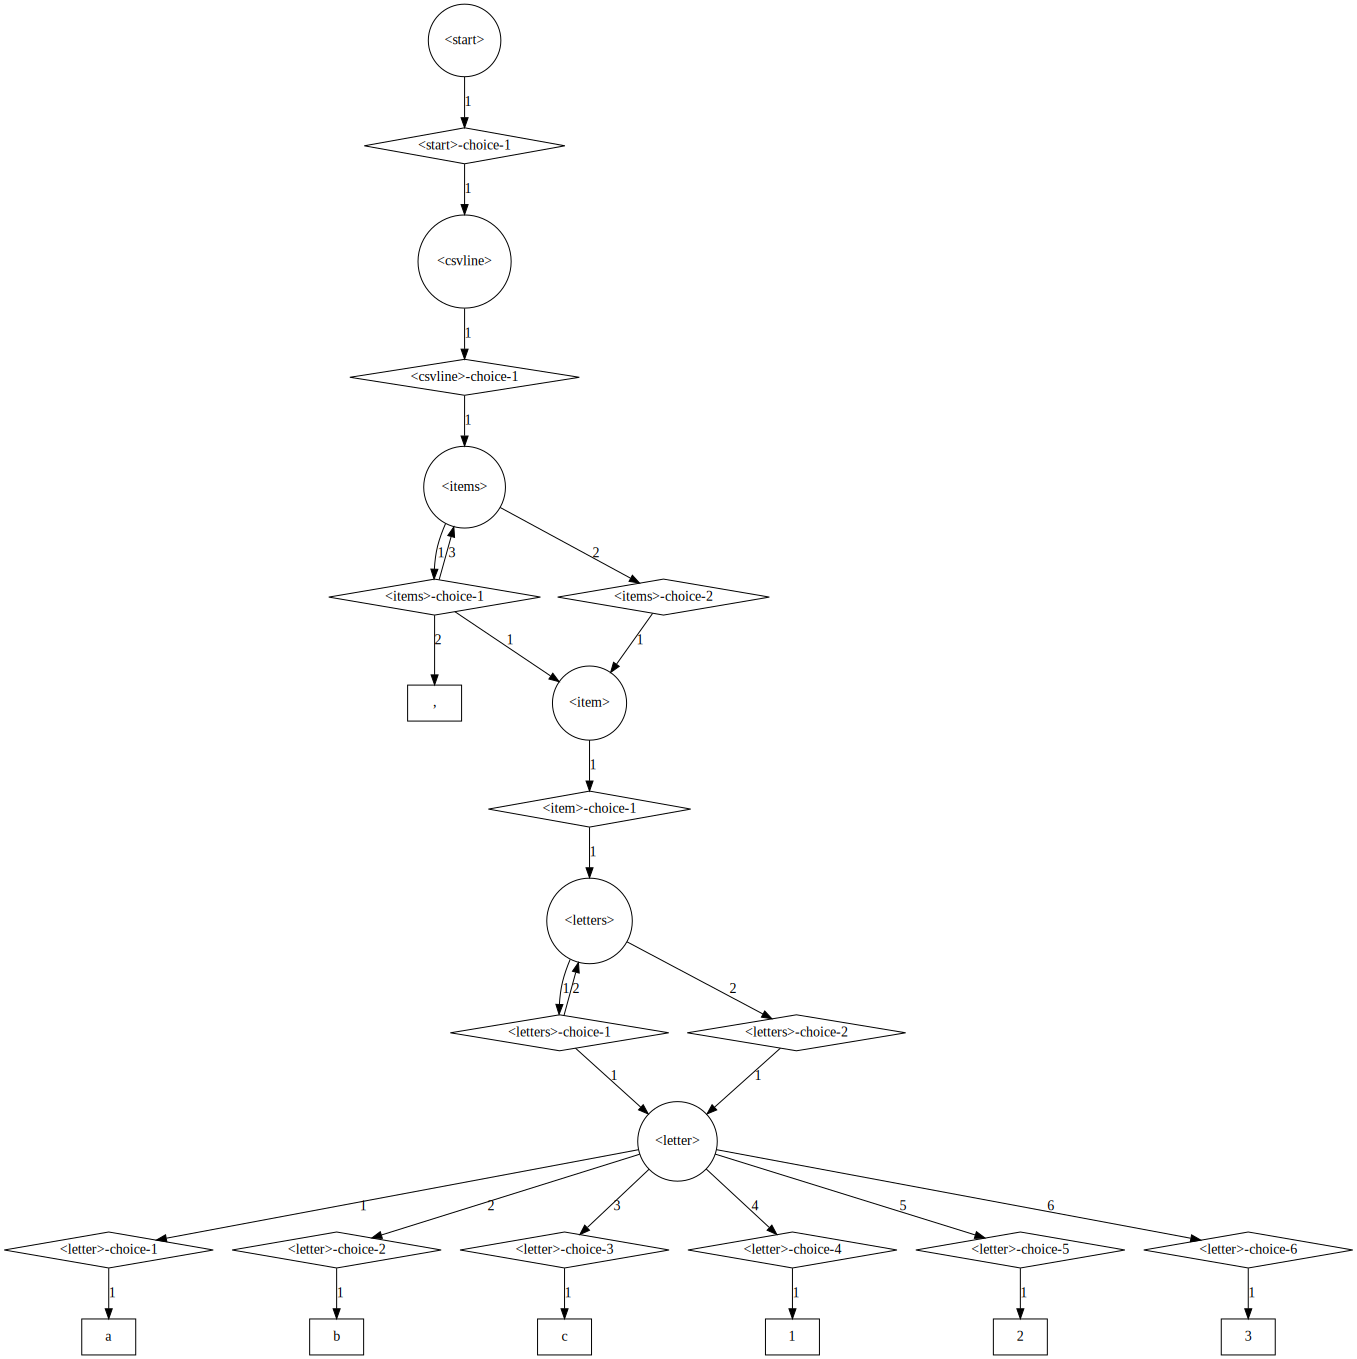

In [3]:
CSV_GRAMMAR["<letter>"] = ['a', 'b', 'c', '1', '2', '3']

from grammar_graph.gg import GrammarGraph

graph = GrammarGraph.from_grammar(CSV_GRAMMAR)
graph.to_dot()

## Sub Graphs

We can create and visualize sub graphs:

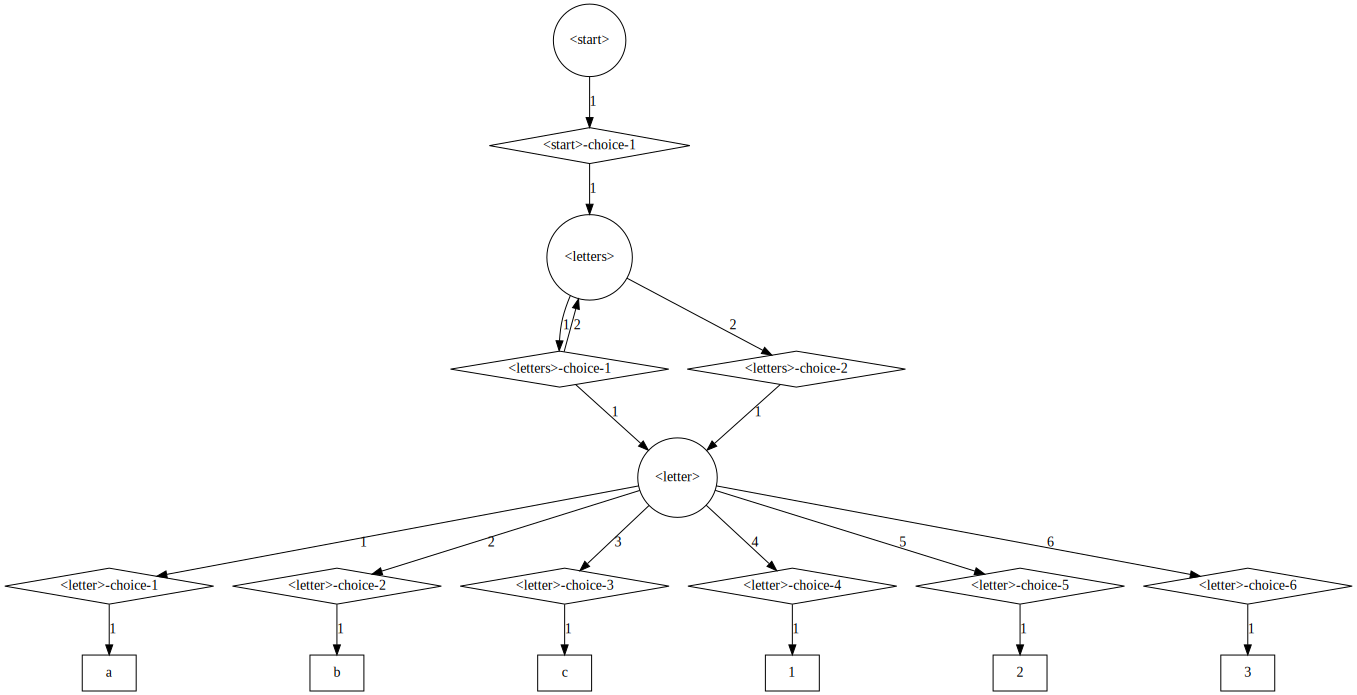

In [4]:
graph.subgraph("<letters>").to_dot()

We can also check whether a subgraph is a tree structure (and can thus, e.g., be trivially
converted to a regular expression), or whether a node is reachable from another one:

In [5]:
graph.subgraph("<letter>").is_tree()

True

In [6]:
graph.subgraph("<letters>").is_tree()

False

In [7]:
letters = graph.get_node("<letters>")
letters.reachable(letters)

True

You can also create a sub grammar from a sub graph.

In [8]:
graph.subgraph("<letters>").to_grammar()

{'<start>': ['<letters>'],
 '<letters>': ['<letter><letters>', '<letter>'],
 '<letter>': ['a', 'b', 'c', '1', '2', '3']}

## Search, Filtering, Shortest Paths

GrammarGraph features implementations of breadth-first search, filtering, and shortest path
discovery (based on Dijkstra's algorithm with Fibonacci heaps). This can, e.g., be used to
embed a subtree into a bigger context. For instance, the shortest path from `<items>` to `<letter>` is:

In [9]:
[node.symbol for node in graph.shortest_path(graph.get_node("<items>"), graph.get_node("<letter>"))]

['<items>', '<item>', '<letters>', '<letter>']

Let us assume we have CSV item `"abc"` from which we want to create a (random) CSV file. We can accomplish
this by finding the shortest path from `<start>` to `<item>` and follow this path, choosing an appropriate
grammar production rule along the way.

In [10]:
from fuzzingbook.Grammars import unreachable_nonterminals, is_nonterminal
from fuzzingbook.Parser import EarleyParser
import copy

item_string = "abc"

# We massage the grammar a little bit to get a tree starting at `<item>`
item_grammar = copy.deepcopy(CSV_GRAMMAR)
item_grammar["<start>"] = ["<item>"]
for unreachable in unreachable_nonterminals(item_grammar):
    del item_grammar[unreachable]

item_tree = next(EarleyParser(item_grammar).parse(item_string))[1][0]
item_tree

('<item>',
 [('<letters>',
   [('<letter>', [('a', [])]),
    ('<letters>',
     [('<letter>', [('b', [])]),
      ('<letters>', [('<letter>', [('c', [])])])])])])

The path we need to follow for creating a complete file embedding `item` is:

In [11]:
item_node = graph.get_node("<item>")

path = [node.symbol for node in graph.shortest_path(graph.root, item_node)]
path

['<start>', '<csvline>', '<items>', '<item>']

So let's create a derivation tree. In principle, such a tree will be incomplete, namely if an
expansion alternative contains nonterminals which we do not have to follow. Such incomplete
nodes have `None` as children and can later on be instantiated, e.g., by a fuzzer. For our simple
CSV grammar, however, this is not the case. In the algorithm sketched below we still account for this.

We use a "canonical" grammar representation for simplicity.

In [12]:
from fuzzingbook.Parser import canonical

canonical_grammar = canonical(CSV_GRAMMAR)
canonical_grammar

{'<start>': [['<csvline>']],
 '<csvline>': [['<items>']],
 '<items>': [['<item>', ',', '<items>'], ['<item>']],
 '<item>': [['<letters>']],
 '<letters>': [['<letter>', '<letters>'], ['<letter>']],
 '<letter>': [['a'], ['b'], ['c'], ['1'], ['2'], ['3']]}

In [13]:
assert graph.root.reachable(item_node)


def wrap_in_tree_starting_in(start_nonterminal: str, tree, grammar, graph: GrammarGraph):
    start_node = graph.get_node(start_nonterminal)
    end_node = graph.get_node(tree[0])
    assert start_node.reachable(end_node)

    derivation_path = [n.symbol for n in graph.shortest_non_trivial_path(start_node, end_node)]

    result = (start_nonterminal, [])
    curr_tree = result
    for path_idx in range(len(derivation_path) - 1):
        path_nonterminal = derivation_path[path_idx]
        next_nonterminal = derivation_path[path_idx + 1]
        alternatives_for_path_nonterminal = [a for a in grammar[path_nonterminal]
                                             if next_nonterminal in a]
        shortest_alt_for_path_nonterminal = \
            [a for a in alternatives_for_path_nonterminal
             if not any(a_ for a_ in alternatives_for_path_nonterminal
                        if len(a_) < len(a))][0]
        idx_of_next_nonterminal = shortest_alt_for_path_nonterminal.index(next_nonterminal)
        for alt_idx, alt_symbol in enumerate(shortest_alt_for_path_nonterminal):
            if alt_idx == idx_of_next_nonterminal:
                if path_idx == len(derivation_path) - 2:
                    curr_tree[1].append(tree)
                else:
                    curr_tree[1].append((alt_symbol, []))
            else:
                curr_tree[1].append((alt_symbol, None if is_nonterminal(alt_symbol) else []))

        curr_tree = curr_tree[1][idx_of_next_nonterminal]

    return result


wrapped_tree = wrap_in_tree_starting_in("<start>", item_tree, canonical_grammar, graph)
wrapped_tree

('<start>',
 [('<csvline>',
   [('<items>',
     [('<item>',
       [('<letters>',
         [('<letter>', [('a', [])]),
          ('<letters>',
           [('<letter>', [('b', [])]),
            ('<letters>', [('<letter>', [('c', [])])])])])])])])])

In [14]:
from fuzzingbook.GrammarFuzzer import tree_to_string

tree_to_string(wrapped_tree)

'abc'

Now let's assume that we want to add another item into that tree. We can do so, e.g., by
replacing the top-level `<items>` node with another `<items>` node expanded once more.
The shortest node from `<items>` to `<items>`, however, is trivial:

In [15]:
items = graph.get_node("<items>")
[node.symbol for node in graph.shortest_path(items, items)]

['<items>']

The function `get_shortest_non_trivial_path` returns a nontrivial path which is useful for
our purposes:

In [16]:
[node.symbol for node in graph.shortest_non_trivial_path(items, items)]

['<items>', '<items>']

The astute reader may have discovered that this method is also used in the above
declaration of `wrap_in_tree_starting_in`, which is why we can use this routine
also for mapping a tree into one starting with the same nonterminal!

In [17]:
items_tree = ('<items>',
              [('<item>',
                [('<letters>',
                  [('<letter>', [('a', [])]),
                   ('<letters>',
                    [('<letter>', [('b', [])]),
                     ('<letters>', [('<letter>', [('c', [])])])])])])])

wrapped_tree = wrap_in_tree_starting_in("<items>", items_tree, canonical_grammar, graph)
wrapped_tree

('<items>',
 [('<item>', None),
  (',', []),
  ('<items>',
   [('<item>',
     [('<letters>',
       [('<letter>', [('a', [])]),
        ('<letters>',
         [('<letter>', [('b', [])]),
          ('<letters>', [('<letter>', [('c', [])])])])])])])])

If we now embed this tree into a one starting in `<start>`, we have an incomplete derivation tree
with a "hole" for another item.

In [18]:
wrapped_tree = wrap_in_tree_starting_in("<start>", wrapped_tree, canonical_grammar, graph)
wrapped_tree

('<start>',
 [('<csvline>',
   [('<items>',
     [('<item>', None),
      (',', []),
      ('<items>',
       [('<item>',
         [('<letters>',
           [('<letter>', [('a', [])]),
            ('<letters>',
             [('<letter>', [('b', [])]),
              ('<letters>', [('<letter>', [('c', [])])])])])])])])])])

In [19]:
tree_to_string(wrapped_tree)

',abc'

Let's complete this tree using the fuzzer:

In [20]:
complete_tree = fuzzer.expand_tree(wrapped_tree)
complete_tree

('<start>',
 [('<csvline>',
   [('<items>',
     [('<item>', [('<letters>', [('<letter>', [('1', [])])])]),
      (',', []),
      ('<items>',
       [('<item>',
         [('<letters>',
           [('<letter>', [('a', [])]),
            ('<letters>',
             [('<letter>', [('b', [])]),
              ('<letters>', [('<letter>', [('c', [])])])])])])])])])])

In [21]:
tree_to_string(complete_tree)

'1,abc'

## k-path Coverage

k-paths is a grammar coverage metric proposed by [Havrikov et al.](https://ieeexplore.ieee.org/document/8952419). The
idea is to extract all paths of length k from the grammar as well as from a derivation tree, and check how many grammar
paths are covered by the derivation tree.

We experiment with an arithmetic expressions grammar, which is the initial example from Havrikov et al.

In [22]:
from fuzzingbook.Grammars import srange

In [23]:
expr_grammar = {
    "<start>": ["<add_expr>"],
    "<add_expr>": ["<mult_expr>", "<add_expr> <add_symbol> <mult_expr>"],
    "<add_symbol>": ["+", "-"],
    "<mult_expr>": ["<unary_expr>", "<mult_expr> <mult_symbol> <unary_expr>"],
    "<mult_symbol>": ["*", "/", "%"],
    "<unary_expr>": ["<id>", "<unary_symbol><unary_expr>", "(<add_expr>)", "<dec_digits>"],
    "<unary_symbol>": ["+", "-", "++", "--"],
    "<dec_digits>": ["<dec_digit><maybe_dec_digits>"],
    "<maybe_dec_digits>": ["", "<dec_digits>"],
    "<dec_digit>": srange(string.digits),
    "<id>": ["x", "y", "z"]
}

First, we obtain the 2-paths from the grammar:

In [24]:
graph = GrammarGraph.from_grammar(expr_grammar)
two_paths = graph.k_paths(2)

print("\n".join(map(str, [" ".join(map(str, [node.symbol for node in path])) for path in two_paths])))

<start> <start>-choice-1 <add_expr>
<add_expr> <add_expr>-choice-1 <mult_expr>
<add_expr> <add_expr>-choice-2 <add_expr>
<add_expr> <add_expr>-choice-2  
<add_expr> <add_expr>-choice-2 <add_symbol>
<add_expr> <add_expr>-choice-2  
<add_expr> <add_expr>-choice-2 <mult_expr>
<mult_expr> <mult_expr>-choice-1 <unary_expr>
<mult_expr> <mult_expr>-choice-2 <mult_expr>
<mult_expr> <mult_expr>-choice-2  
<mult_expr> <mult_expr>-choice-2 <mult_symbol>
<mult_expr> <mult_expr>-choice-2  
<mult_expr> <mult_expr>-choice-2 <unary_expr>
<add_symbol> <add_symbol>-choice-1 +
<add_symbol> <add_symbol>-choice-2 -
<unary_expr> <unary_expr>-choice-1 <id>
<unary_expr> <unary_expr>-choice-2 <unary_symbol>
<unary_expr> <unary_expr>-choice-2 <unary_expr>
<unary_expr> <unary_expr>-choice-3 (
<unary_expr> <unary_expr>-choice-3 <add_expr>
<unary_expr> <unary_expr>-choice-3 )
<unary_expr> <unary_expr>-choice-4 <dec_digits>
<mult_symbol> <mult_symbol>-choice-1 *
<mult_symbol> <mult_symbol>-choice-2 /
<mult_symbol> 

Next, we get all 2-paths from the derivation tree of `x + 42`:

In [25]:
parser = EarleyParser(expr_grammar)
tree = list(parser.parse("x + 42"))[0]
tree_two_paths = graph.k_paths_in_tree(tree, 2)

In [26]:
print("\n".join(map(str, [" ".join(map(str, [node.symbol for node in path])) for path in tree_two_paths])))

<start> <start>-choice-1 <add_expr>
<add_expr> <add_expr>-choice-2 <add_expr>
<add_expr> <add_expr>-choice-1 <mult_expr>
<add_expr> <add_expr>-choice-2  
<add_expr> <add_expr>-choice-2 <add_symbol>
<add_symbol> <add_symbol>-choice-1 +
<add_expr> <add_expr>-choice-2  
<add_expr> <add_expr>-choice-2 <mult_expr>
<mult_expr> <mult_expr>-choice-1 <unary_expr>


This gives rise to the k-path coverate metric:

In [27]:
coverage = len(tree_two_paths) / len(two_paths)
coverage

0.1956521739130435

We can also call the method `k_path_coverage` directly:

In [28]:
graph.k_path_coverage(tree, 2)

0.1956521739130435

Our input's 3-path coverage is worse, while its 1-path coverage (simple coverage of nonterminals) is better:

In [29]:
graph.k_path_coverage(tree, 3)

0.11764705882352941

In [30]:
graph.k_path_coverage(tree, 1)

0.5454545454545454

Let us fuzz some inputs and check their, say, 3-path coverage:

In [40]:
fuzzer = GrammarCoverageFuzzer(expr_grammar)
for _ in range(20):
    tree = fuzzer.expand_tree(("<start>", None))
    print(f"{(tree_to_string(tree) + ',').ljust(40)} coverage: {round(graph.k_path_coverage(tree, 3)*100, 2)} %")

++(y / z - x % y + y * 8 % x),           coverage: 58.82 %
--++-++937415026373,                     coverage: 14.12 %
6 / -z,                                  coverage: 15.29 %
x / z / (x + z) * ((z % y)),             coverage: 42.35 %
(++--z * y) / 032 + 82 % 4 + x + z / 0 % -z, coverage: 75.29 %
-(x / +z + (x - z) + 7 * (x)),           coverage: 63.53 %
--x % y / ((1 - --21)),                  coverage: 48.24 %
3,                                       coverage: 1.18 %
(9 % z * -31 / 394 + +861) % ++x,        coverage: 61.18 %
x * y * x % 3 * (x + y + x + (x)),       coverage: 51.76 %
x % --(z) - (z / y % z) / 3,             coverage: 54.12 %
0,                                       coverage: 1.18 %
--+99 * 1 % 0,                           coverage: 31.76 %
z / z + 4 / ++(++y * 50 * ((x)) % -(y % y / y) * (x)), coverage: 70.59 %
x + x - x * z * (y - x) - x,             coverage: 47.06 %
++x + 310,                               coverage: 21.18 %
4 % (z % x % --z) / +++--((+(z - x) / 46

We think that representing CFGs as graphs is useful for a number of purposes such as the one
we looked into just now. Hopefully it can help you too!